In [1]:
import numpy as np
import pandas as pd
from numpy import pi as pi
from scipy import interpolate
import matplotlib.pyplot as plt

In [2]:
def d(x,y):
    return -np.log(np.exp(-(((x-y)**2+(1e-20)**2)**.5))+np.exp(-(180-((x-y)**2+(1e-20)**2)**.5)))

# gaussian function and stimulus function
def gaussian(x, y, sigma): # Gaussian function centered at y
    return np.exp(-np.power(d(x,y), 2.) / (2 * np.power(sigma, 2.)))

def hfunc(x, phi, sigma_FF): # stimulus of orientation phi
    return gaussian(x, phi, sigma_FF)

# threshold quadratic transfer function
def f(k, n, Ialpha):
    return k*(np.power((np.maximum(Ialpha,0)), n))

# Independent noise

In [11]:
def two_ring_model(t0, T, dt, phi, N, tau_E, tau_I, tau_n, c_ne, c_ni, J_EE, J_II, J_EI, J_IE, sigma_ori, sigma_FF, k, n, c, a, b):
    # firing rate vectors for ring 1 and ring 2
    r1 = np.zeros((2*N,1))
    r2 = np.zeros((2*N,1))
    r_E1 = np.zeros((N,1))
    r_I1 = np.zeros((N,1))
    r_E2 = np.zeros((N,1))
    r_I2 = np.zeros((N,1))

    # matrices to store firing rates as row and time as column
    R_ss = np.zeros((4*N, 1))
    R_n = np.zeros((4*N, 1))

    xs = np.linspace(0, N-1, N)

    G_ori = np.fromfunction(lambda x,y: gaussian(x,y,sigma_ori), (N,N)) # Connectivity matrix 
    h = np.array([hfunc(x, phi, sigma_FF) for x in range(N)]) # has shape (180,)
    h = h[:,None] # makes shape (180,1)

    W_E1E1 = W_E2E2 = J_EE*G_ori
    W_E1I1 = W_E2I2 = J_EI*G_ori
    W_I1E1 = W_I2E2 = J_IE*G_ori
    W_I1I1 = W_I2I2 = J_II*G_ori

    W_E1E2 = b*W_E2E2 # b scales ring2 output connectivity strength wrt within ring2 connectivity strength
    W_E1I2 = b*W_E2I2
    W_I1E2 = b*W_I2E2
    W_I1I2 = b*W_I2I2

    W_E2E1 = a*W_E1E1 # a scales ring1 output connectivity strength wrt within ring1 connectivity strength
    W_E2I1 = a*W_E1I1
    W_I2E1 = a*W_I1E1
    W_I2I1 = a*W_I1I1

    W = np.block([
        [W_E1E1, W_E1I1, W_E1E2, W_E1I2], 
        [W_I1E1, W_I1I1, W_I1E2, W_I1I2], 
        [W_E2E1, W_E2I1, W_E2E2, W_E2I2], 
        [W_I2E1, W_I2I1, W_I2E2, W_I2I2]
    ])
    
    sgn = np.block([
        [np.ones((4*N,N)), -np.ones((4*N,N)), np.ones((4*N,N)), -np.ones((4*N,N))]
    ])


    h = np.block([
        [h],
        [h],
        [h],
        [h]
    ])

    r_ss = np.block([
        [r_E1],
        [r_I1], 
        [r_E2], 
        [r_I2]
    ])
    
    r_n = np.block([
        [r_E1],
        [r_I1], 
        [r_E2], 
        [r_I2]
    ])
    
    # initial inputs 
    Id = c*h + (sgn*W)@r_ss
    In = c*h + (sgn*W)@r_n
    
    
    # smoothed noise process 
    eta = np.zeros((4*N, 1))
    
    # vector of E/I timescales 
    tau = np.block([
        [np.full((N,1), tau_E)],
        [np.full((N,1), tau_I)],
        [np.full((N,1), tau_E)],
        [np.full((N,1), tau_I)]
    ])
    
    # vector of noise magnitudes
    c_n = np.block([
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ni)],
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ni)]
    ])
    
    M = int(T/dt)
    ts = np.arange(M+1)
    
    for m in range(M):
    # deterministic sim
        r_ss += dt*(1/tau)*(-r_ss + f(k, n, Id))
        Id = c*h + (sgn*W)@r_ss
        R_ss = np.c_[R_ss, r_ss]
    # noise sim
        x = np.random.randn(4*N,1)
        eta += (1/tau_n) * (-eta * dt + np.sqrt(2*tau_n*dt)*x)
        r_n += dt*(1/tau)*(-r_n + f(k, n, In + c_n*eta))
        In = c*h + (sgn*W)@r_n # note: sgn matrix incorporates minus signs for I
        R_n = np.c_[R_n, r_n]
        
    return r_ss, r_n, R_ss, R_n, W, xs, ts, c, h

In [110]:
r_ss, r_n, R_ss, R_n, W, xs, ts, c, h = two_ring_model(t0=0, 
                                             T=500, 
                                             dt=0.1, 
                                             phi=45, 
                                             N=180, 
                                             tau_E=20, 
                                             tau_I=10, 
                                             tau_n = 1, 
                                             c_ne=1, 
                                             c_ni=1, 
                                             J_EE=0.044, 
                                             J_II=0.018, 
                                             J_EI=0.023, 
                                             J_IE=0.042, 
                                             sigma_ori=32, 
                                             sigma_FF=30, 
                                             k=0.04, 
                                             n=2.0, 
                                             c=40,
                                             
                                             a=.2, 
                                             b=.3)

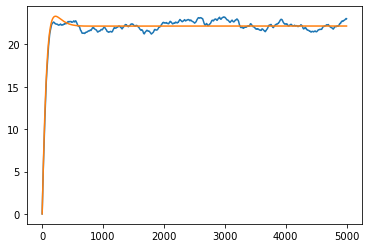

In [111]:
plt.plot(R_n[45,:])
plt.plot(R_ss[45,:])
plt.show()

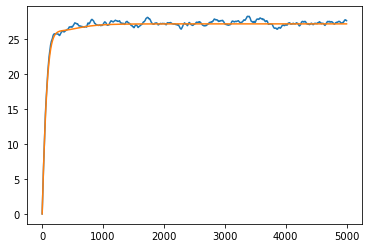

In [112]:
plt.plot(R_n[360+45,:])
plt.plot(R_ss[360+45,:])
plt.show()

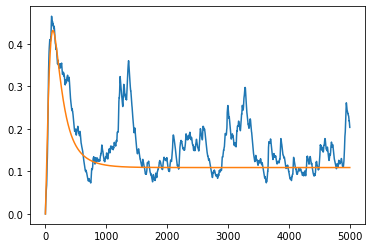

In [113]:
plt.plot(R_n[340,:])
plt.plot(R_ss[340,:])
plt.show()

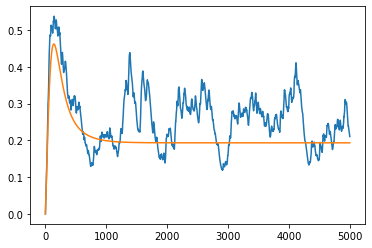

In [114]:
plt.plot(R_n[700,:])
plt.plot(R_ss[700,:])
plt.show()

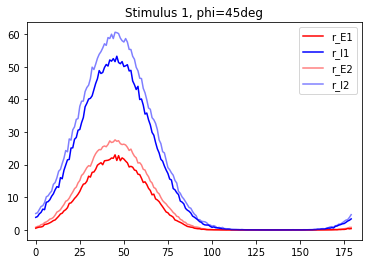

In [115]:
N = 180

plt.plot(r_n[:N], label='r_E1', color='r', alpha=1)
plt.plot(r_n[N:2*N], label='r_I1', color='b', alpha=1)
plt.plot(r_n[2*N:3*N], label='r_E2', color='r', alpha=.5)
plt.plot(r_n[3*N:], label='r_I2', color='b', alpha=.5)
plt.title('Stimulus 1, phi=45deg')
plt.xlim(-5,185)
plt.legend()
plt.show()

## Theory

In [116]:
xs = np.arange(-100,20000)
df = interpolate.InterpolatedUnivariateSpline(xs, np.diff(f(0.04, 2, xs), prepend=0))

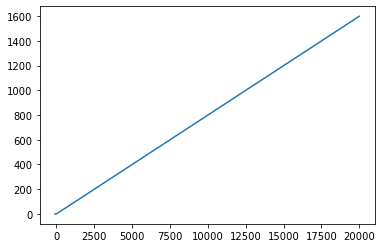

In [117]:
plt.plot(xs, df(xs))
plt.show()

The weight matrix $\mathbf{W}$ is 
$$
\mathbf{W} = 
\begin{bmatrix}
    \mathbf{W}^{(1)} & \mathbf{W}^{(12)}\\
    \mathbf{W}^{(21)} & \mathbf{W}^{(2)}
\end{bmatrix}
$$

where 
$$
\mathbf{W}^{(1)} = 
\begin{bmatrix}
    \mathbf{W}^{(1)}_{EE} & \mathbf{W}^{(1)}_{EI} \\
    \mathbf{W}^{(1)}_{IE} & \mathbf{W}^{(1)}_{II}
\end{bmatrix}
$$
and the others are similar.

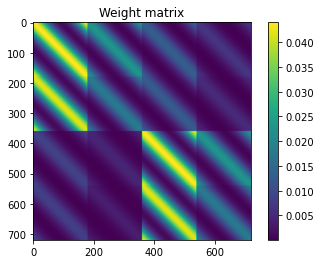

In [118]:
plt.imshow(W)
plt.colorbar()
plt.title('Weight matrix')
plt.show()

To compute the linearization, we will have to evaluate $\frac{df}{dI}\Bigg|_{I = I_{a, \text{ eff}}}$ where 
$$I^{(j)}_{a, \text{ eff}} = 
c\mathbf{h} 
+
\mathbf{W}^{(j)}_{aE} \cdot \mathbf{\overline{r}}^{(j)}_E
-
\mathbf{W}^{(j)}_{aI} \cdot \mathbf{\overline{r}}^{(j)}_I
$$

Below is what this derivative looks like for $a = E$:

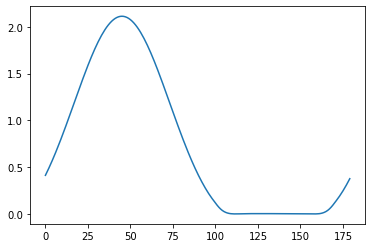

In [119]:
W1_EE = W[:N,:N]
W1_EI = W[:N,N:2*N]
W1_IE = W[N:2*N,:N]
W1_II = W[N:2*N, N:2*N]

plt.plot(df(c*h[:N] + W1_EE@r_ss[:N] - W1_EI@r_ss[N:2*N]))
plt.show()

The linearization matrix $\mathbf{L}$ is the diagonal matrix of the derivative of the transfer function $f$ evaluated at the steady state values,

$$
\mathbf{L}
=
\text{diag}\left(\frac{df}{dI}(I^{(1)}_{E, \text{ eff}}), \frac{df}{dI}(I^{(1)}_{I, \text{ eff}}), \frac{df}{dI}(I^{(2)}_{E, \text{ eff}}), \frac{df}{dI}(I^{(2)}_{I, \text{ eff}})\right)
$$


In [120]:
sgn = np.block([
        [np.ones((4*N,N)), -np.ones((4*N,N)), np.ones((4*N,N)), -np.ones((4*N,N))]
    ])
L = np.diagflat(np.array(df(c*h + (sgn*W)@r_ss)))

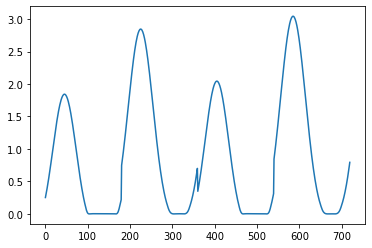

In [121]:
plt.plot(df(c*h + (sgn*W)@r_ss))
plt.show()

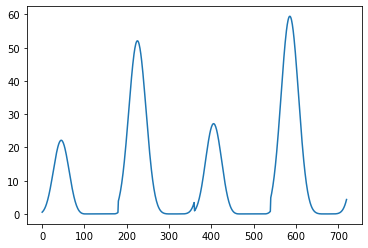

In [122]:
plt.plot(f(.04, 2, c*h + (sgn*W)@r_ss))
plt.show()

$$
\mathbf{M} 
=
\begin{bmatrix}
    -\mathbb{1} + \mathbf{L}^{(1)}_{E}\cdot \mathbf{W}^{(1)}_{EE} & -\mathbf{L}^{(1)}_{E}\cdot\mathbf{W}^{(1)}_{EI}\\
    \mathbf{L}^{(1)}_{I}\cdot \mathbf{W}^{(1)}_{IE} & -\mathbb{1} - \mathbf{L}^{(1)}_I\cdot\mathbf{W}^{(1)}_{II} \\
    &  & -\mathbb{1} + \mathbf{L}^{(2)}_{E}\cdot \mathbf{W}^{(2)}_{EE} & \mathbf{L}^{(2)}_{E}\cdot\mathbf{W}^{(2)}_{EI} \\ 
    &  & 
    \mathbf{L}^{(2)}_{I}\cdot \mathbf{W}^{(2)}_{IE} & -\mathbb{1} - \mathbf{L}^{(2)}_I\cdot\mathbf{W}^{(2)}_{II} 
\end{bmatrix}
$$

$$
\mathbf{D} =
\sqrt{2\tau_n}
\begin{bmatrix}
    \sigma_E \mathbf{L}_E^{(1)} & & & \\
     & \sigma_I \mathbf{L}_I^{(1)} & &\\
     & & \sigma_E \mathbf{L}_E^{(2)} & \\
     & & & \sigma_I \mathbf{L}_I^{(2)}
\end{bmatrix}
$$

In [123]:
LW = L@W

Eye = np.eye(N)
c_ne=1
c_ni=1
tau_n=1

L1eW1ee = LW[:N, :N]
L1eW1ei = LW[:N, N:2*N]
L1iW1ie = LW[N:2*N, :N]
L1iW1ii = LW[N:2*N, N:2*N]

L2eW2ee = LW[2*N:3*N, 2*N:3*N]
L2eW2ei = LW[2*N:3*N, 3*N:4*N]
L2iW2ie = LW[3*N:4*N, 2*N:3*N]
L2iW2ii = LW[3*N:4*N, 3*N:4*N]

M = np.block([
    [-Eye + L1eW1ee, -L1eW1ei, np.zeros((N,2*N))],
    [L1iW1ie, -Eye - L1iW1ii, np.zeros((N,2*N))],
    [np.zeros((N,2*N)), -Eye + L2eW2ee, -L2eW2ei],
    [np.zeros((N,2*N)), L2iW2ie, -Eye - L2iW2ii]
])

Minv = np.linalg.inv(M)
c_n = np.diagflat(np.block([
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ni)],
        [np.full((N,1), c_ne)],
        [np.full((N,1), c_ni)]
    ]))

D = c_n@L
D = np.sqrt(2*tau_n)*D

Sigma = Minv @ D @ (( Minv @ D).T)

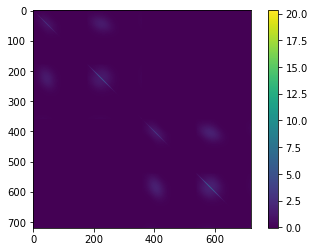

In [124]:
plt.imshow(Sigma)
plt.colorbar()
plt.show()

In [125]:
Sigma1_E = Sigma[:N, :N]
Sigma2_E = Sigma[2*N:3*N, 2*N:3*N]
Sigma12_E = Sigma[:N, 2*N:3*N]

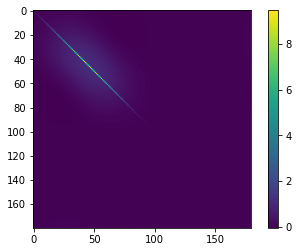

In [126]:
plt.imshow(Sigma2_E)
plt.colorbar()
plt.show()

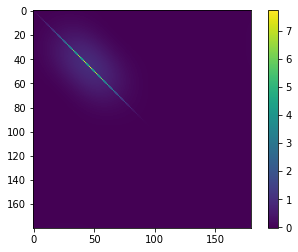

In [127]:
plt.imshow(Sigma1_E)
plt.colorbar()
plt.show()

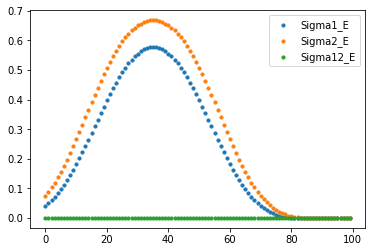

In [128]:
offdiag1 = [Sigma1_E[i, i+20] for i in range(100)]
offdiag2 = [Sigma2_E[i, i+20] for i in range(100)]
offdiag12 = [Sigma12_E[i, i+20] for i in range(100)]

xs = np.arange(100)
plt.scatter(xs, offdiag1, label='Sigma1_E', s=10)
plt.scatter(xs, offdiag2, label='Sigma2_E', s=10)
plt.scatter(xs, offdiag12, label='Sigma12_E', s=10)
plt.legend()
plt.show()